# Preprocess Tutorial

You have successfully designed a scRNA-seq experiment - you isolated single cells, captured their transcripts, and generated sequencing libraries where the transcripts were mapped to individual cells. Now you have raw data in the form of a counts matrix. So, what do we do with this counts matrix? How can we use this data to start to answer interesting biological questions and even generate new hypotheses?

This series of scRNA-seq tutorials - Preprocess, Cluster Analysis, and Pseudotime Analysis - will take you through a standard scRNA-seq analysis workflow geared toward developmental biologists. Bioinformatics is a big field, and new and exciting methods and advancements are coming out all the time. Therefore, it is - quite frankly - impossible to cover everything in a single workshop (or even a full semester-long course!). However, these tutorials will serve as a great foundation for most scRNA-seq analyses.

These tutorials assume that upstream preprocessing has been completed. This includes base calling, mapping, and read counting, which is frequently handled by the 10x Genomics analysis pipeline Cell Ranger.

This notebook is largely adapted from an [ipython notebook](https://github.com/theislab/single-cell-tutorial) provided by the Theis Lab as part of their Molecular Systems Biology submission "Current best practices in single‐cell RNA‐seq analysis: a tutorial" ([Luecken and Theis, 2019](https://doi.org/10.15252/msb.20188746)). Both the notebook and paper are worth checking out to get a more in-depth idea of the steps involved with scRNA-seq analysis (and the "best" ways to do them!).

For these tutorials, we will be working with a publicly available scRNA-seq dataset of human cerebral organoids generated using 10x Genomics and preprocessed using Cell Ranger ([Kanton et al., 2019](https://www.nature.com/articles/s41586-019-1654-9#citeas)). This dataset is used in an excellent [scRNA-seq tutorial](https://github.com/quadbiolab/scRNAseq_analysis_vignette/blob/master/Tutorial.md#now-lets-start-part-1) using R and Seurat by Zhisong He and Barbara Treutlein, which we also highly recommend.

# Table of Contents

* [1 Downloading the Data](#1-Downloading-the-Data)
* [2 Setting up the Coding Environment](#1-Setting-up-the-Coding-Environment)
* [3 Reading in the Data](#2-Reading-in-the-Data)
* [4 Quality Control](#3-Quality-Control)
* [5 Normalization](#4-Normalization)
* [6 Highly Variable Genes](#5-Highly-Variable-Genes)
* [7 Visualization](#6-Visualization)

# 1 Downloading the Data

The first thing we need to do is download our data. We are going to do this within our Docker container. We are going to get the following three files:
* *matrix.mtx.gz* (`https://github.com/quadbiolab/scRNAseq_analysis_vignette/raw/master/data/DS1/matrix.mtx.gz`)
* *features.tsv.gz* (`https://github.com/quadbiolab/scRNAseq_analysis_vignette/raw/master/data/DS1/features.tsv.gz`)
* *barcodes.tsv.gz* (`https://github.com/quadbiolab/scRNAseq_analysis_vignette/raw/master/data/DS1/barcodes.tsv.gz`)

These files are what are generated by running Cell Ranger. *matrix.mtx.gz* is the counts matrix (stored in Market Exchange Format for sparse matrices). *features.tsv.gz* are the features (genes) that correspond to the row indices in the counts matrix. For each feature, its feature ID and name are stored in the first and second column of the *features.tsv.gz* file. *barcodes.tsv.gz* are the barcode sequences, which correspond to column indices in the counts matrix. 

To download this data into our Docker container, hit the "New Launcher" button (the blue button with the plus sign). Scroll to the bottom of the launcher and click "Terminal" to open a terminal. You should a blank screen with a single `#` and blinking cursor.

First, let's make a new *raw_data* directory in our *workspace* folder. To get your current working directory, type `pwd` and hit enter. You should get `/app`. To move into the *workspace* folder, type `cd workspace` and hit enter. Now if you type `pwd` and hit enter you should get `/app/workspace`. To make our new *raw_data* directory, type `mkdir raw_data` and hit enter. If you type `ls` and hit enter you should see a new directory called *raw_data*. To download our data files, move into the *raw_data* directory with `cd raw_data` (to make sure you're in the right place, `pwd` should now give you `/app/workspace/raw_data`). Copy the url link for the *matrix.mtx.gz* file. In your terminal, type `wget `, paste in the url, and hit enter (so, the line in your terminal would look like: `# wget https://github.com/quadbiolab/scRNAseq_analysis_vignette/raw/master/data/DS1/matrix.mtx.gz`). Do the same thing for the *features.tsv.gz* and *barcodes.tsv.gz* files.

Now if look at our left sidebar, we should see a new *raw_data* folder that contains our three data files. Piece of cake, right?

One more thing while we're using the terminal. Let's navigate into the *scanpy* folder and make two new folders, one called *results* and one called *figures*. We'll use the *results* folder to save our scRNA-seq analysis object, which stores all the components of our downstream analysis, and we'll use the *figures* folder to save any plots we want to keep.

# 2 Setting up the Coding Environment

In order to perform a scRNA-seq analysis, we need to set up our coding environment (this Jupyter notebook!). This involves loading (or importing) all of the python modules, packages, and libraries we need via the [`import`](https://docs.python.org/3/reference/import.html) statement. A python [`module`](https://docs.python.org/3/tutorial/modules.html) is a file that can define functions, classes and variables, and also include runnable code. A `script` is an executable module (also sometimes called a `program` or `application`. A python package is a collection of modules under a common namespace. You can kind of think of a package like a file system directory and modules as the files in the directory, though this is an oversimplification. A `library` is a generic term for a bunch of code that was designed with the aim of being usable by many applications. It provides some generic functionality that can be used by specific applications. For example, [`pandas`](https://pandas.pydata.org/) is a python library to analyze and manipulate data and is very popular in the data science field. `pandas` is also the basis of the [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) data structure used in `scanpy`. [`matplotlib`](https://matplotlib.org/) is a python library used for data visualization and generating graphs and plots. [`numpy`](https://numpy.org/) is python package used to process and manage arrays (a special variable that can hold more than one value at a time). Using `from...import...` allows us to import specific attributes of a module/package/library, and using `import...as...` allows us to rename modules/packages/libraries as they are imported for more concise function calls downstream (for instance, if we said `import scanpy` and wanted to use the `read_10x_mtx` scanpy function, we would have to call this as `scanpy.read_10x_mtx`. If we said `import scanpy as sc` we could instead call `sc.read_10x_mtx`).

In [1]:
# main scRNA-seq analysis toolkit
import scanpy as sc

# data science tools
import numpy as np
import scipy as sp
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

# handles warnings; we are importing this to actually suppress some annoyting warning messages downstream
import warnings

# operating system interface
import os

# R-to-python conversion; for the preprocessing notebook we use this for the normalization step (scran)
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri
from rpy2.rinterface import RRuntimeWarning

In [2]:
# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(2,2) # rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(dpi=200, dpi_save=300, format='ps') # scanpy figure parameters
#sc.logging.print_versions() # prints out version info for modules/packages/libraries used in the notebook. Important for reproducibility! 

In [3]:
%%R

# Load the R library scran for normalization step
library(scran)

It is also useful to specify the paths for some files and directories. In this next code chunk, we wil specify an output *figures* directory where we can save save plots. We will also specify an input directory *data_dir* that contains our raw data (the files we downloaded in part 1). Finally, we will specify a *results* file where we can store our analysis results.

In [6]:
# Files and Directories
sc.settings.figdir = './figures/'
data_dir = '../raw_data/'
results = './results/scanpy_tutorial.h5ad'

# 3 Reading in the Data

Scanpy has a built-in function to easily read in Cell Ranger output data and create an AnnData object, which stores scRNA-seq data in cells x genes format. Note that this is not the same as in R! If you are doing a scRNA-seq analysis in R using a toolkit like Seurat, you would need to transpose your data so that it is in genes x cells format. Data is typically stored in genes x cells format on GEO, which would need to be transposed to cells x genes format for use with Scanpy.

In [8]:
# Read in the data and create AnnData object
adata = sc.read_10x_mtx(
    data_dir, # the directory with the `.mtx` file
    var_names = 'gene_symbols', # use gene symbols for the variable names (variables-axis index)
    cache = True) # write a cache file for faster subsequent reading

adata.var_names_make_unique() # this is not necessary when specifying `var_names = 'gene_ids'` in `sc.read_10x_mtx`

... writing an h5ad cache file to speedup reading next time


In [9]:
adata

AnnData object with n_obs × n_vars = 4672 × 33694
    var: 'gene_ids', 'feature_types'

# 4 Quality Control

Quality control can be split into two main parts: cell QC and gene QC. 

Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell (though, it should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration). Therefore, the most common quality control is to filter out: 1) cells with too few genes detected (these usually represent cells which are not sequenced deep enough for reliable characterization), 2) cells with too many genes detected (doublets!), and 3) cells with high mitochondrial transcript percentage.

Concerning gene QC, it is typically a good idea to filter out genes that are detected in a low number of cells as these are unlikely to be informative. 

Note: there is no one-size-fits-all filtering criteria. It's best to *only filter out outlier cells*, i.e. the minority of cells with certain QC metrics clearly above or below the majority of cells. In general, it is good practice to be permissive in the early filtering steps. After doing some initial visualization and clustering you can re-assess your data and determine if more stringent filtering is needed.

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

In [11]:
# `sc.pp.calculate_qc_metrics` returns several calculated metrics including:
# -number of genes with positive counts in a cell (n_genes_by_counts)
# -total number of counts for a cell (total_counts)
# -pct_counts_mt (proportion of total counts for a cell which are mitochondrial)

# If we look at our adata object, we can see the addition of several QC metrics
adata

AnnData object with n_obs × n_vars = 4672 × 33694
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

There are several different ways to plot QC metrics. A violin plot of some of the computed quality metrics can give us a quick idea of the number of genes expressed per cell in the counts matrix, the total counts per cell, and the percentage of counts per cell belonging to mitochondrial genes (generally anything below ~20-25% is considered acceptable for most data sets).

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


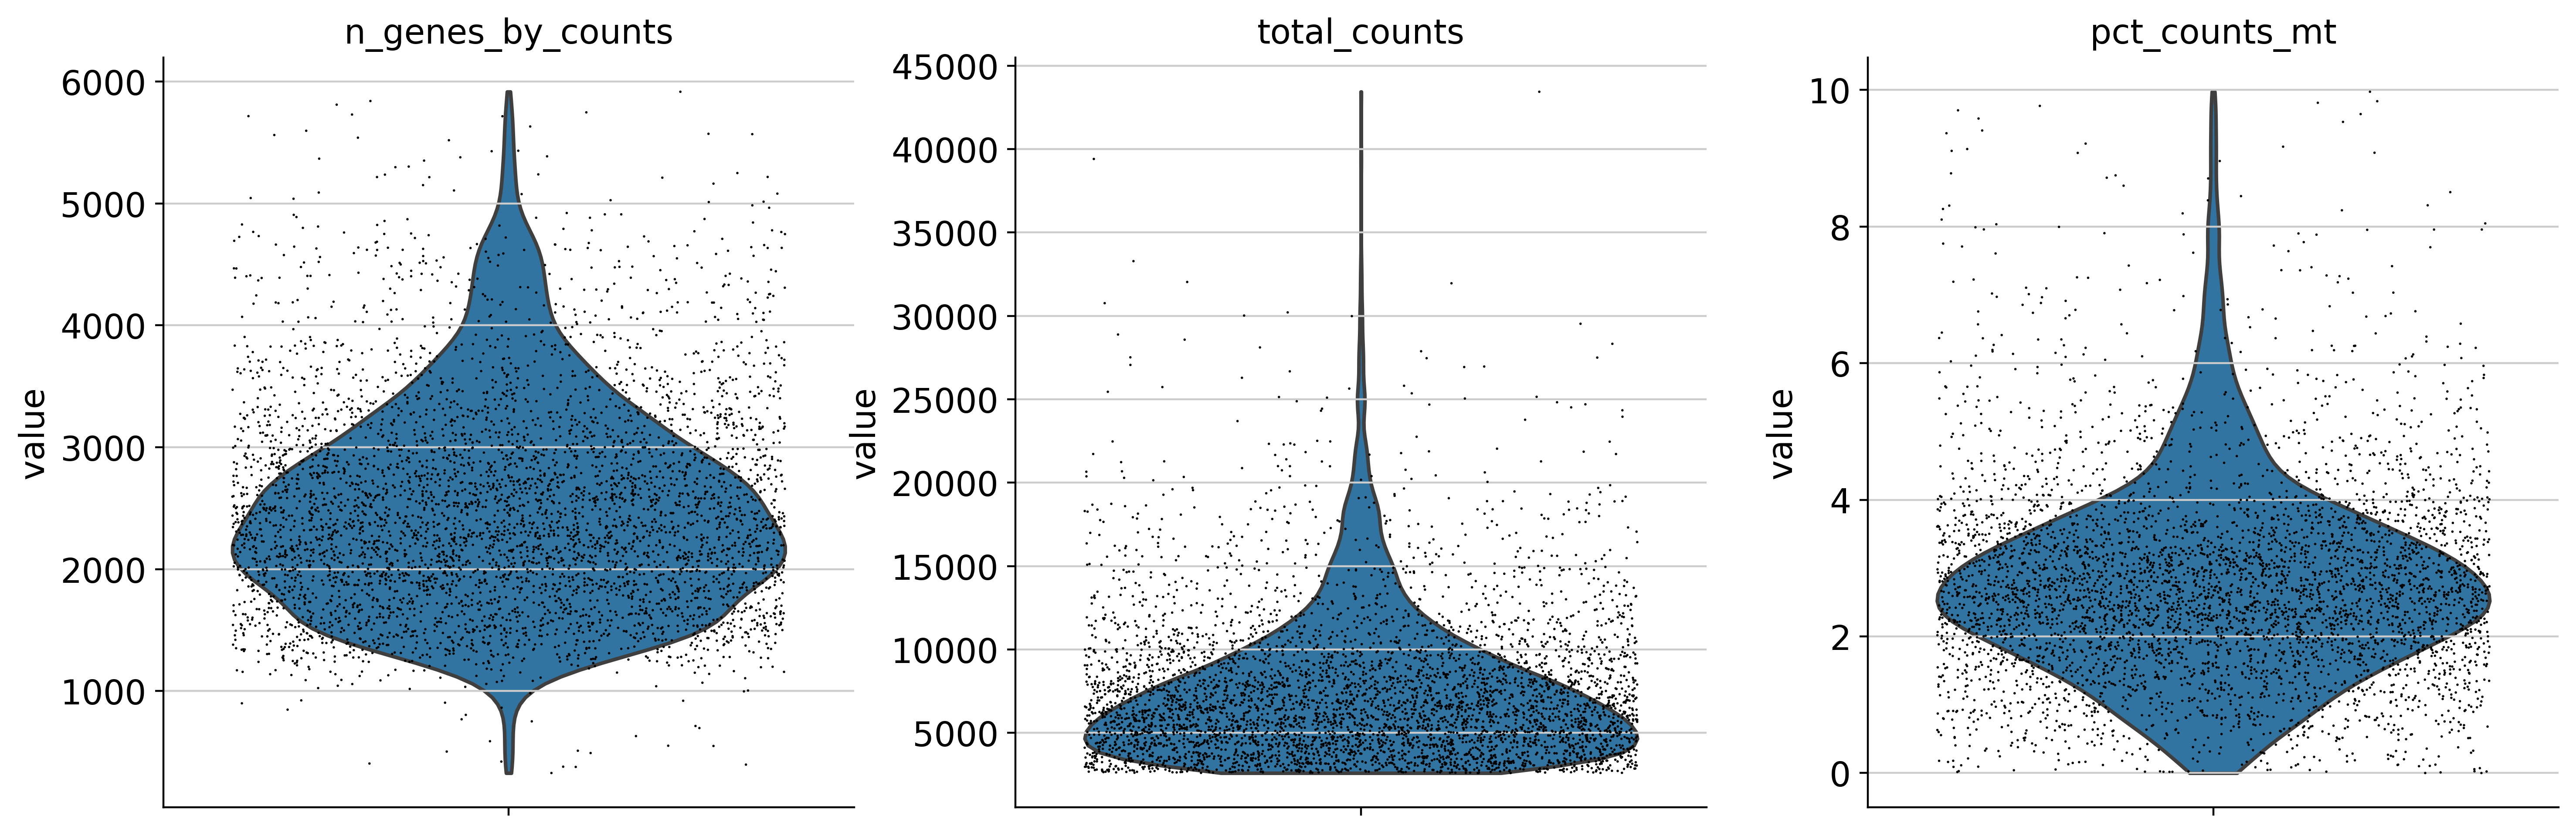

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

We can also look at plots of the number of genes per cell versus the number of counts per cell colored by mitochondrial fraction information. By looking at our QC metrics jointly like this we can get a better example of what's going on in our data. For instance, a group of cells with many counts but few genes could initially be characterized as "dying" outliers. However, if they don't seem to show a high fraction of mitochondrial counts then they might not actually be "dying" and could be worth keeping in our data. Along similar lines, cells with lower counts and genes that tend to have a higher fraction of mitochondrial counts are likely under stress or are dying and should be removed from the dataset (when apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus and therefore fewer counts overall and thus a higher fraction of mitochondrial counts). Cells with high mitochondrial activity with higher counts and genes per cell could indicate biologically relevant mitochondrial activity.

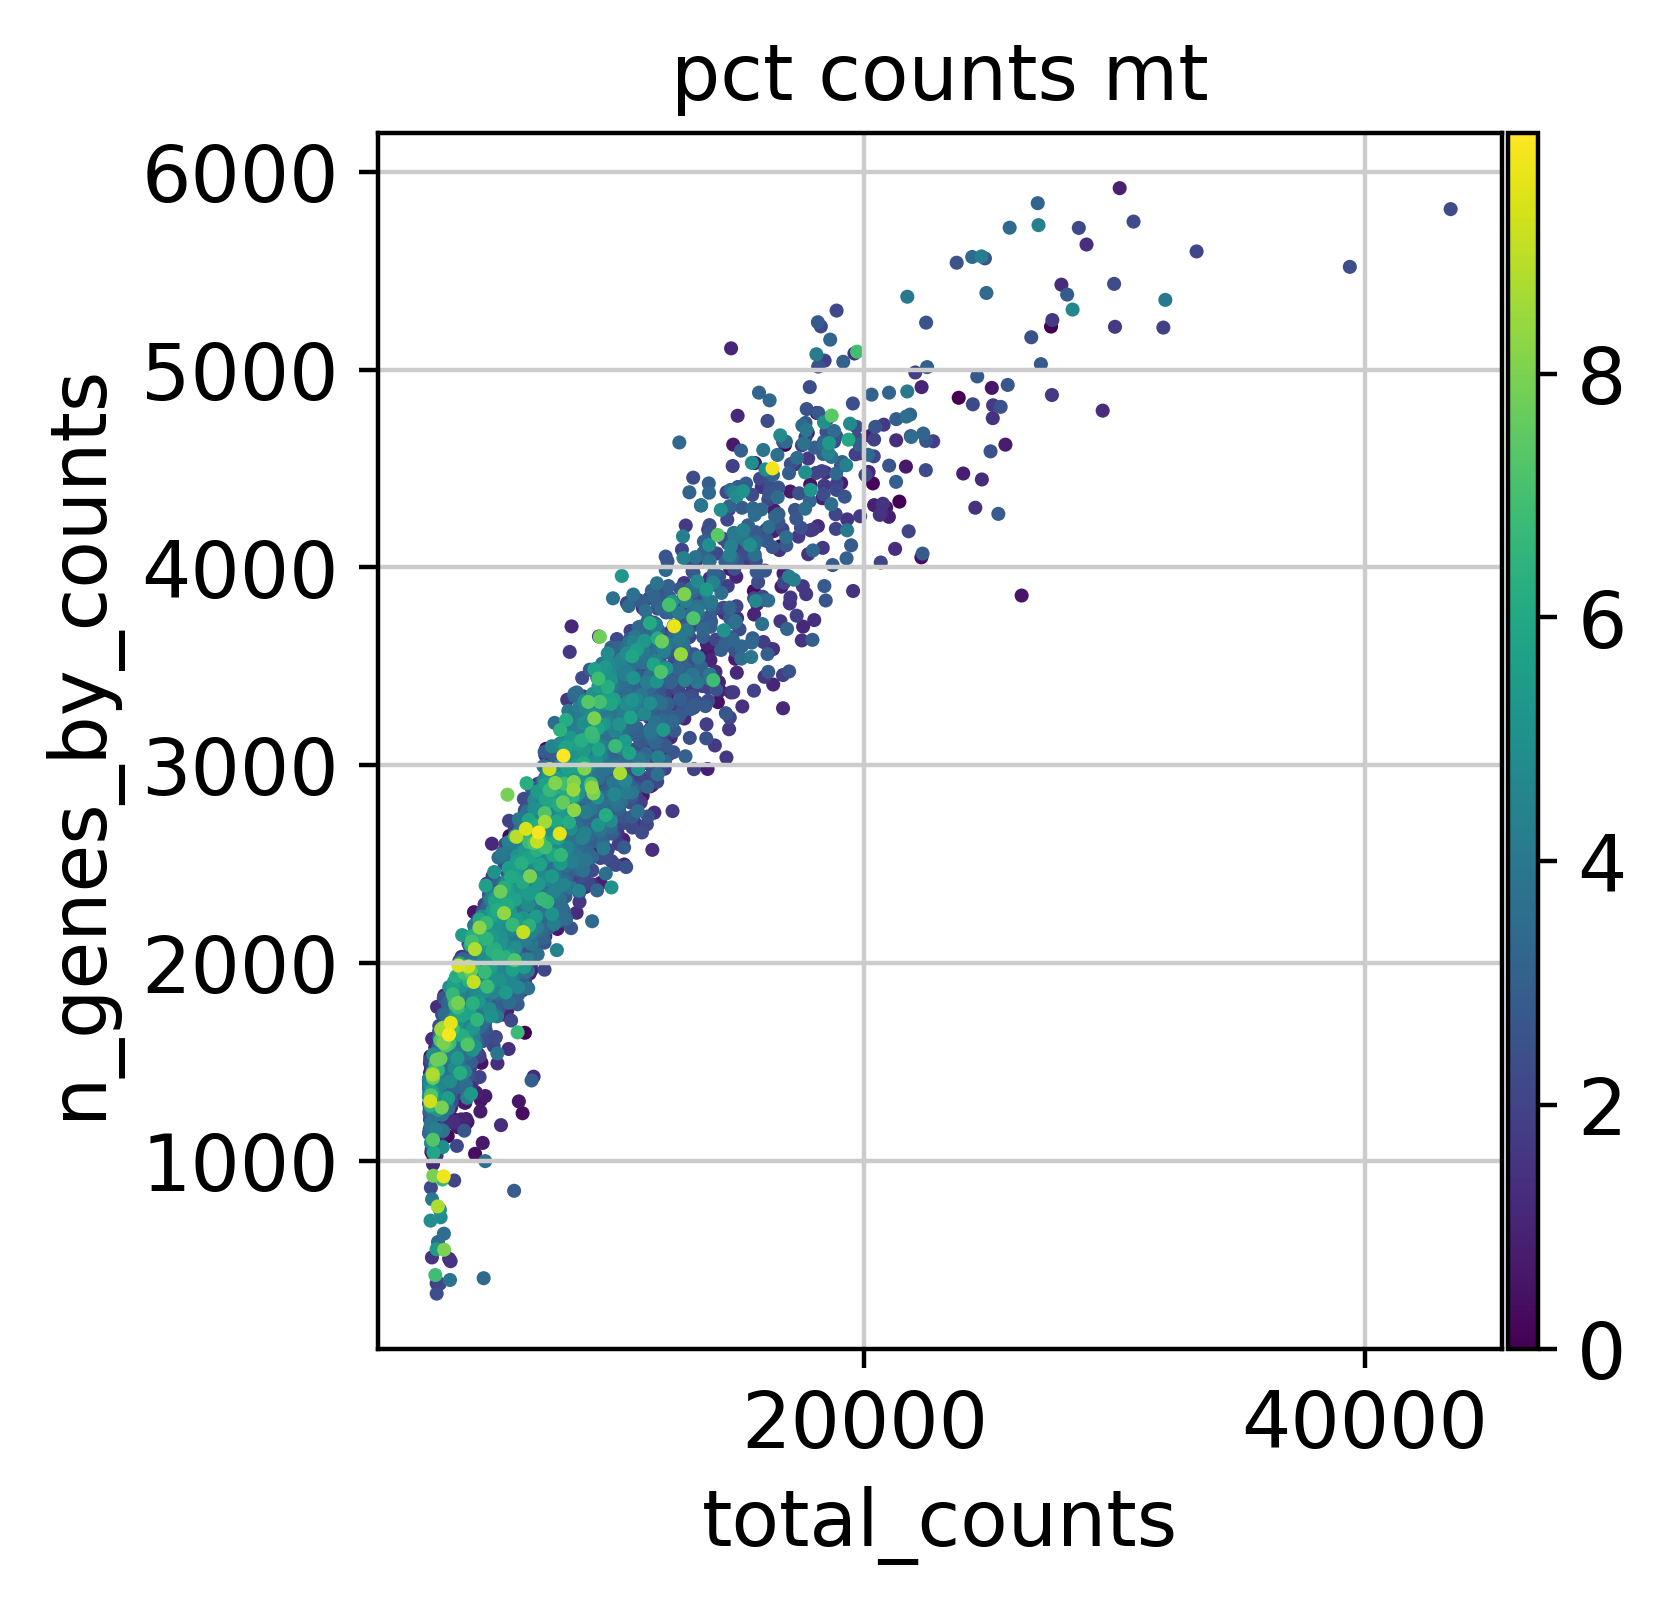

In [13]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_mt') 

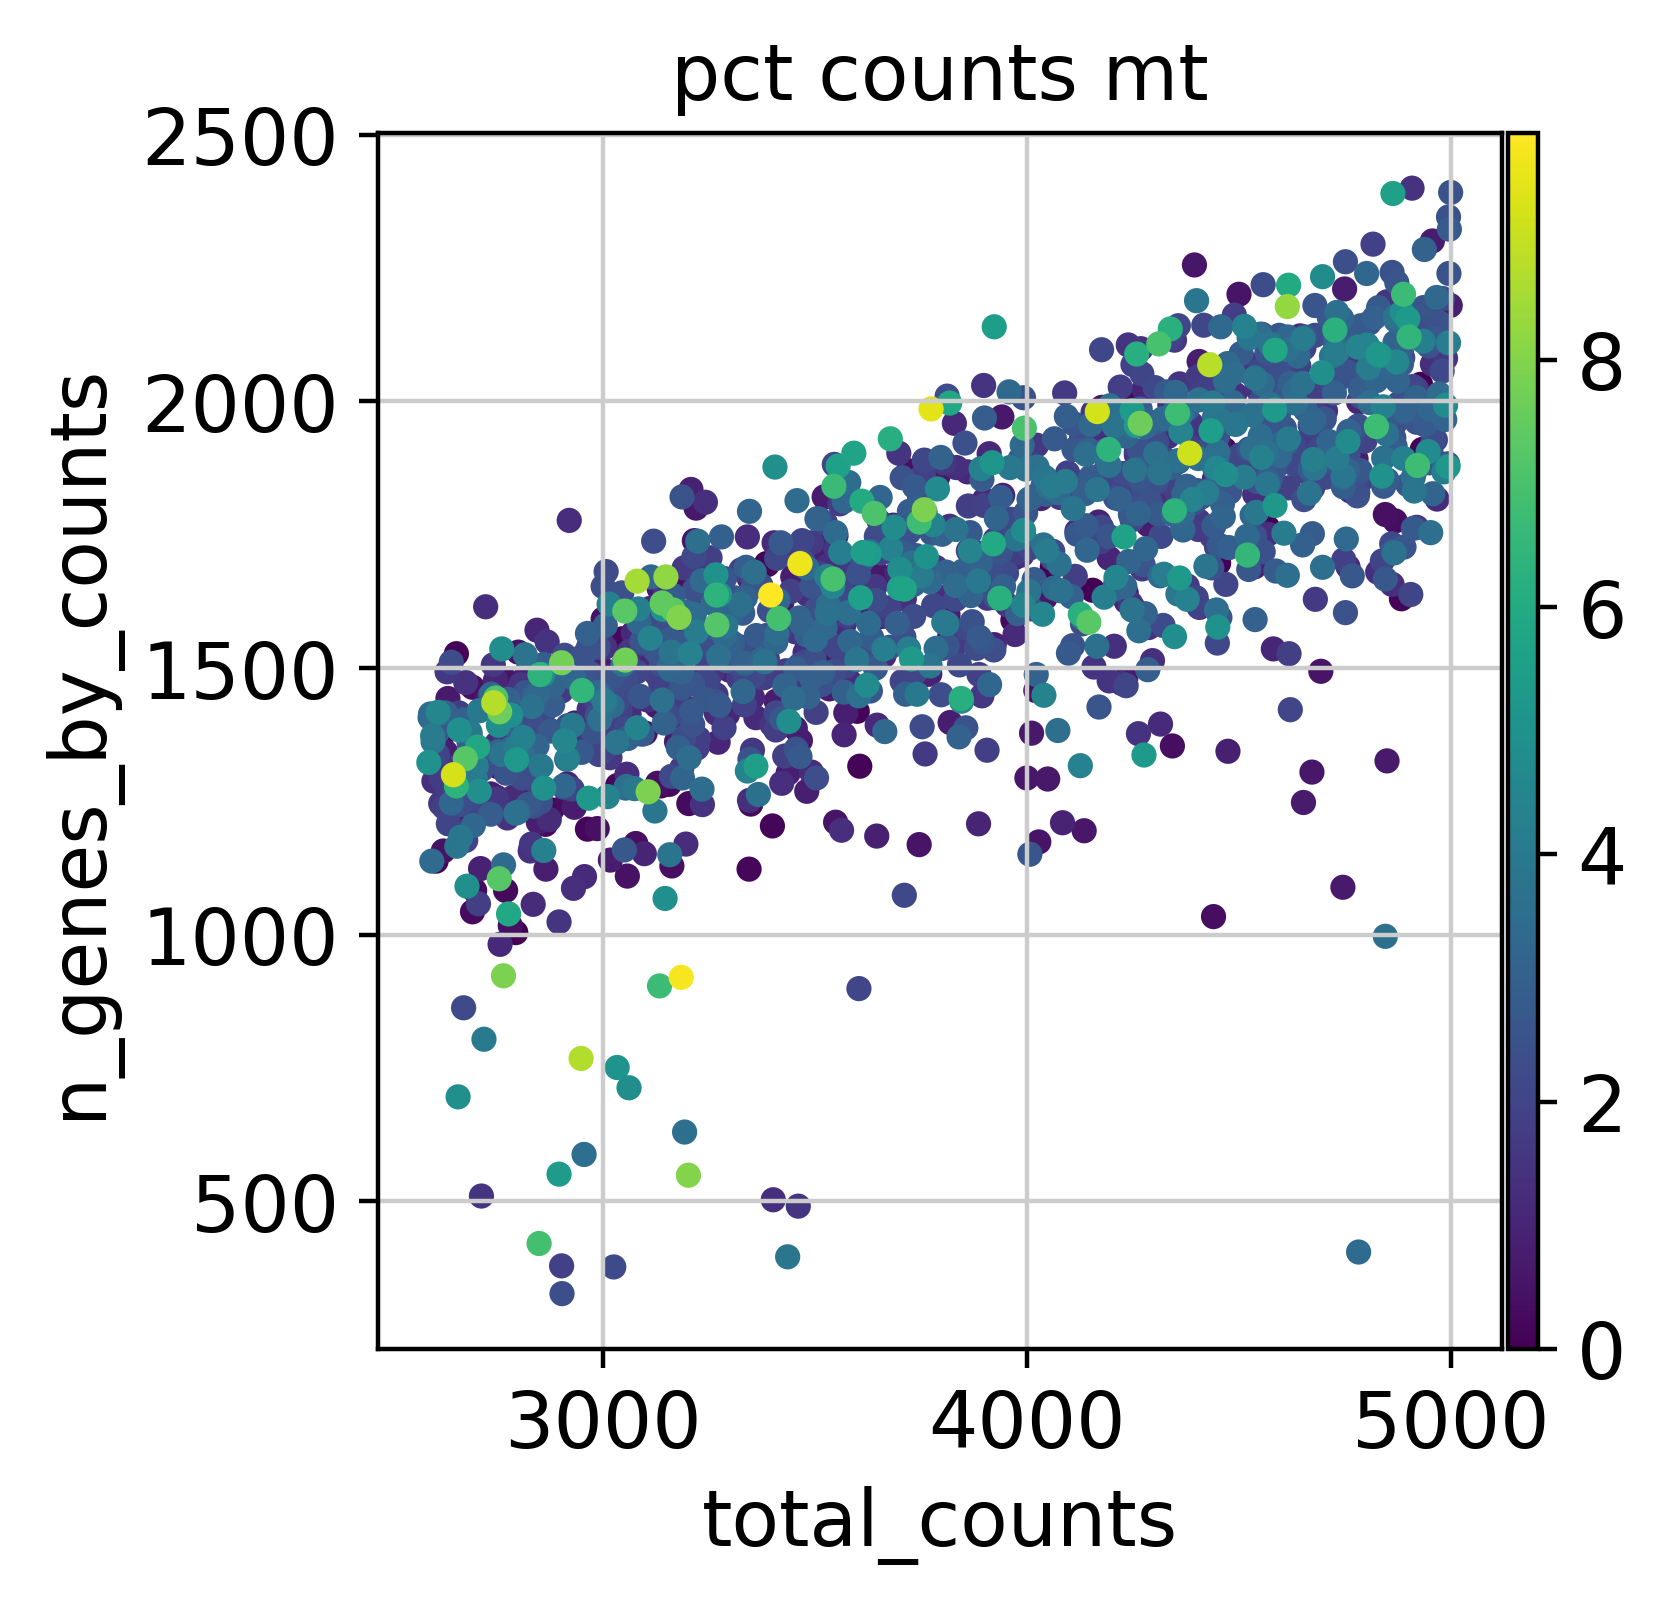

In [14]:
# this is the same plot as above, but 'zoomed' in on cells with less than 5000
sc.pl.scatter(adata[adata.obs['total_counts']<5000], 'total_counts', 'n_genes_by_counts', color='pct_counts_mt') 

Histograms are another helpful way to assess the quality of your data. We can look for small peaks of groups of cells on the lower and upper end of counts and compare them to the overall distribution of counts. Often these small peaks are uninformative, with peaks on the lower end of counts representing potential cellular debris found in droplets and peaks on the upper end of counts representing doublets.

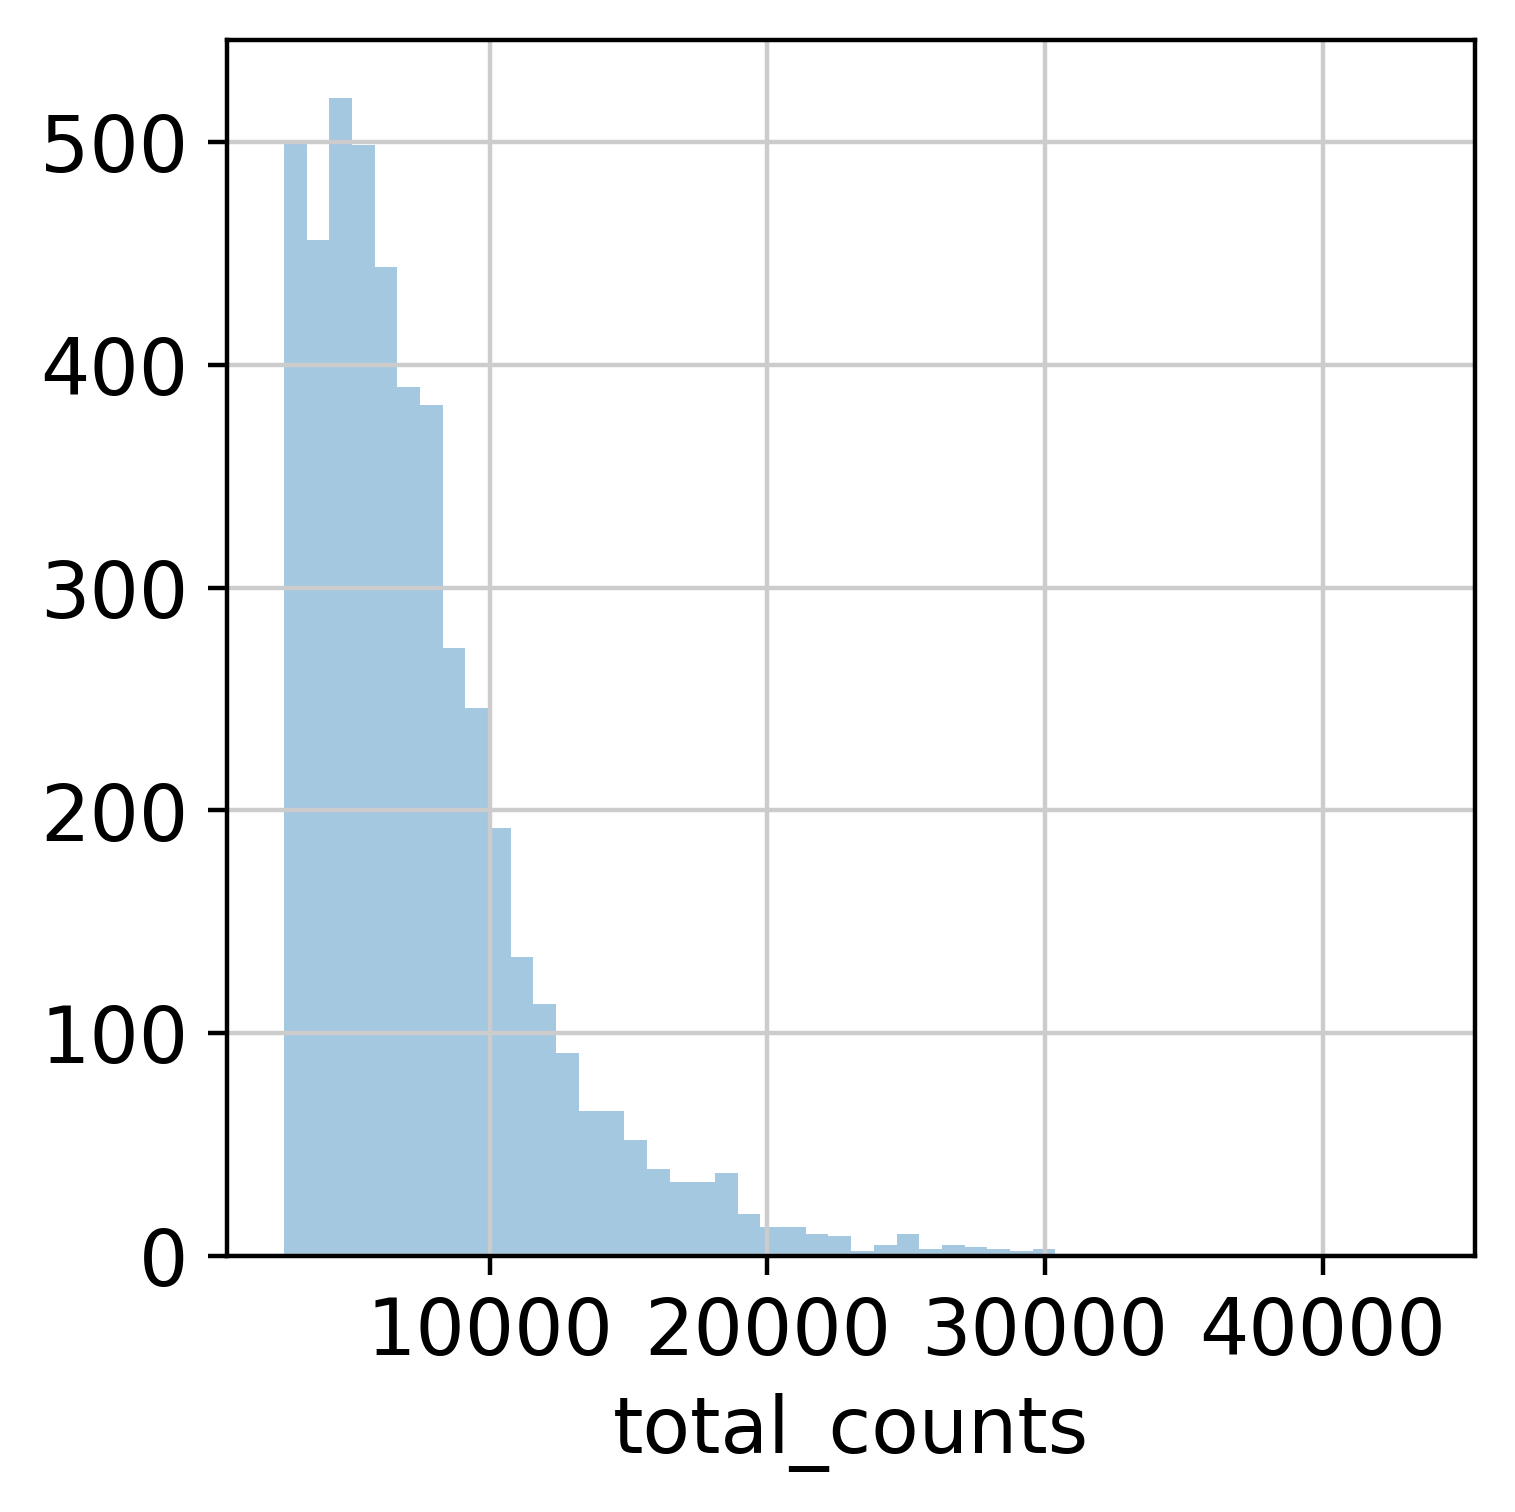

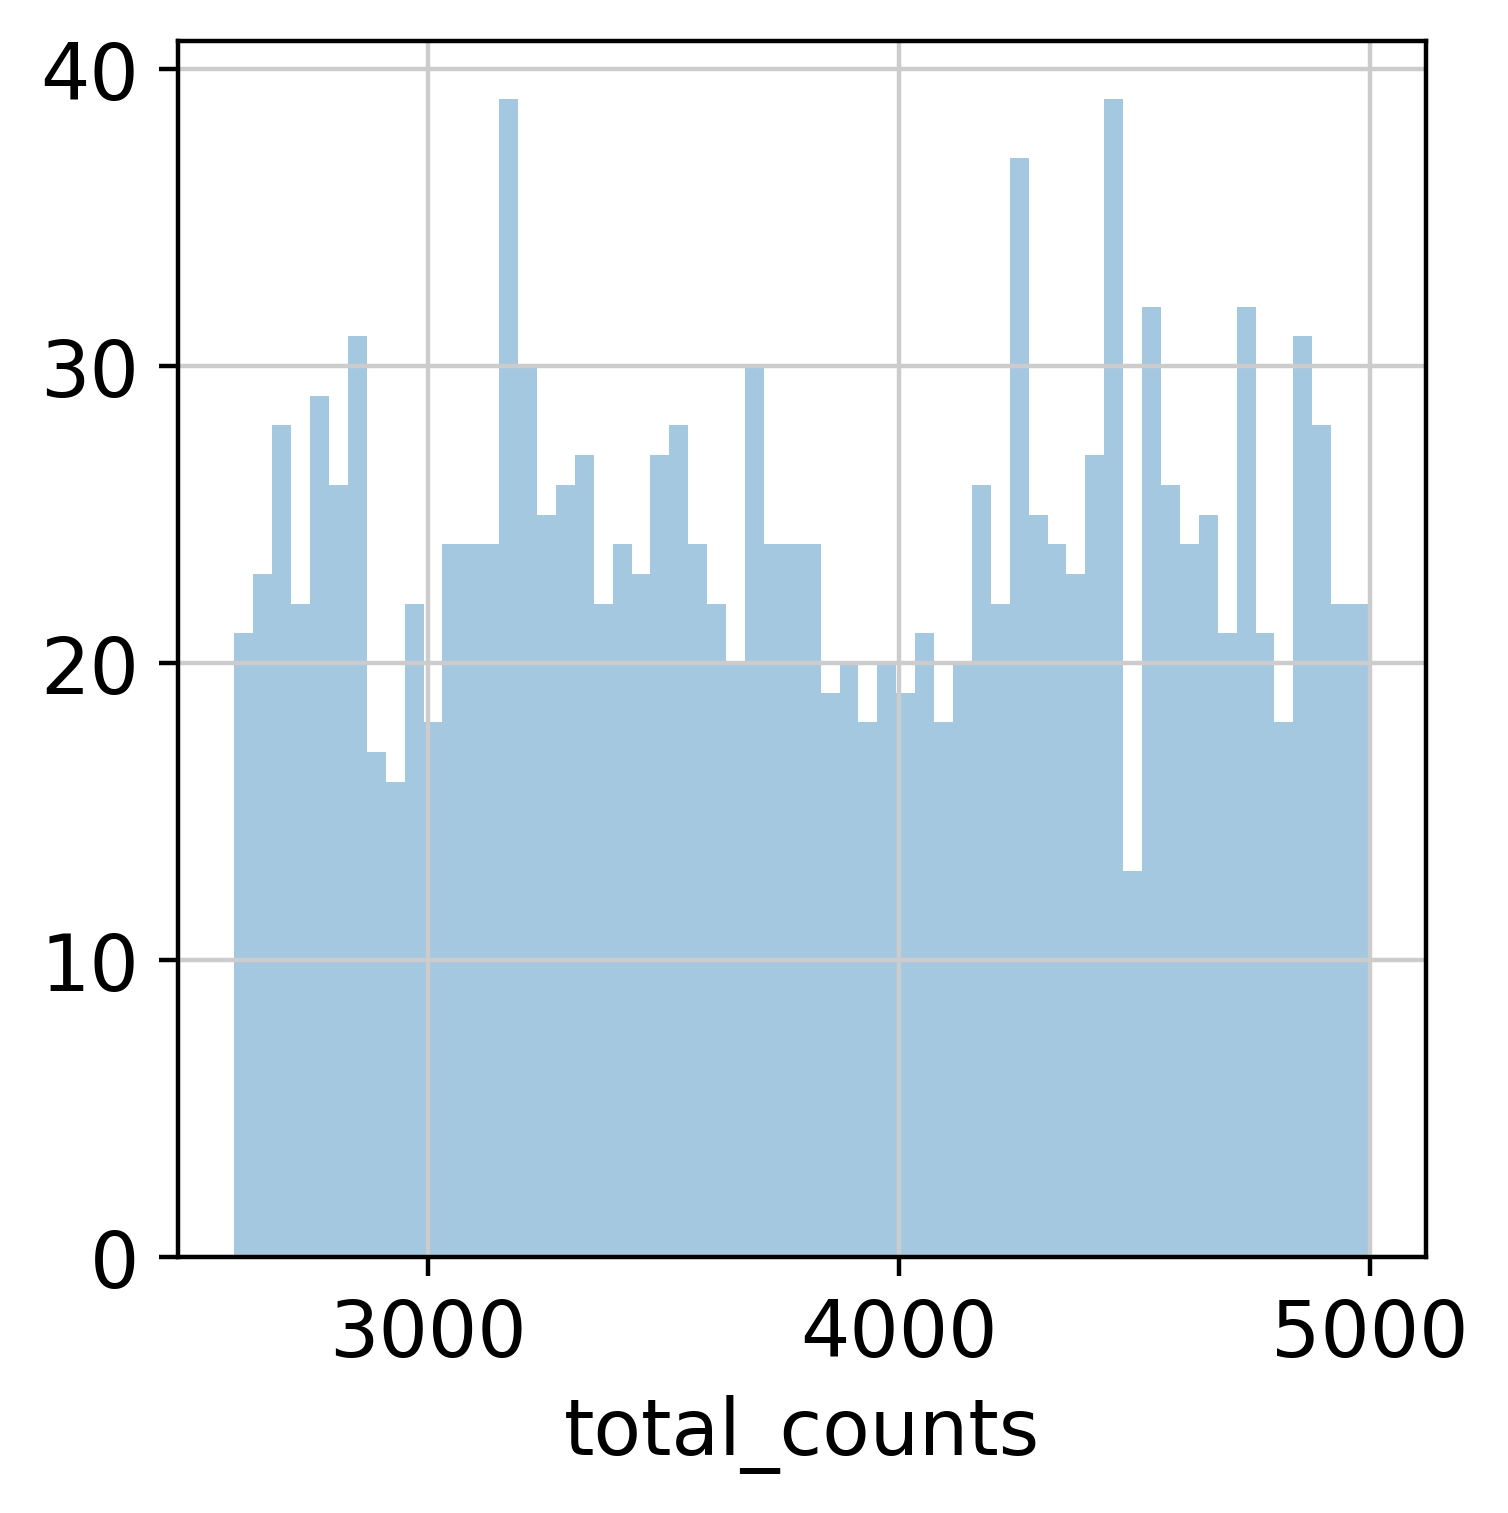

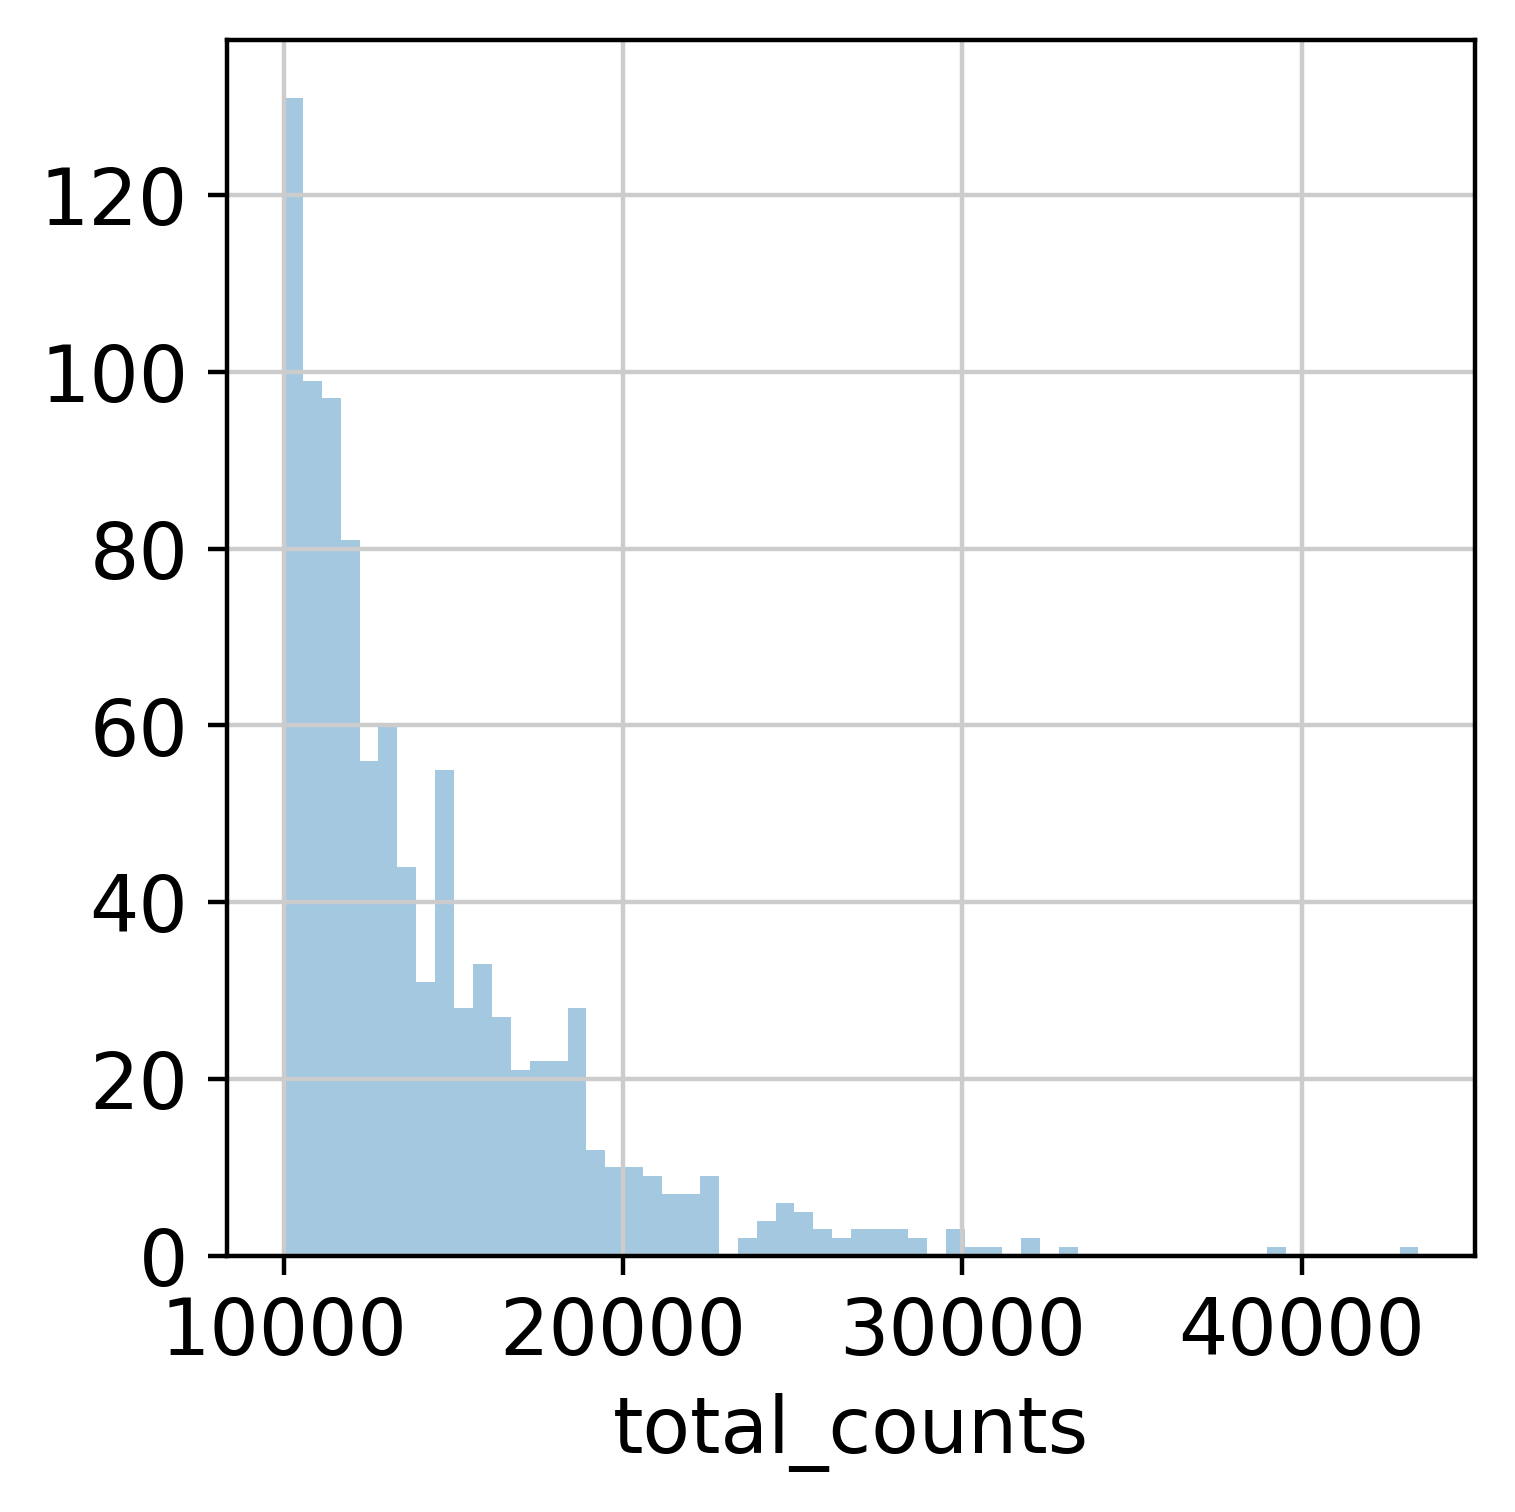

In [18]:
# Thresholding decision: counts
p1 = sb.distplot(adata.obs['total_counts'], kde=False)
plt.show()

p2 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<5000], kde=False, bins=60)
plt.show()

p3 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']>10000], kde=False, bins=60)
plt.show()

We can also look at gene counts, which combined with the joint plot of genes vs counts above should help us determine our filtering cutouffs.

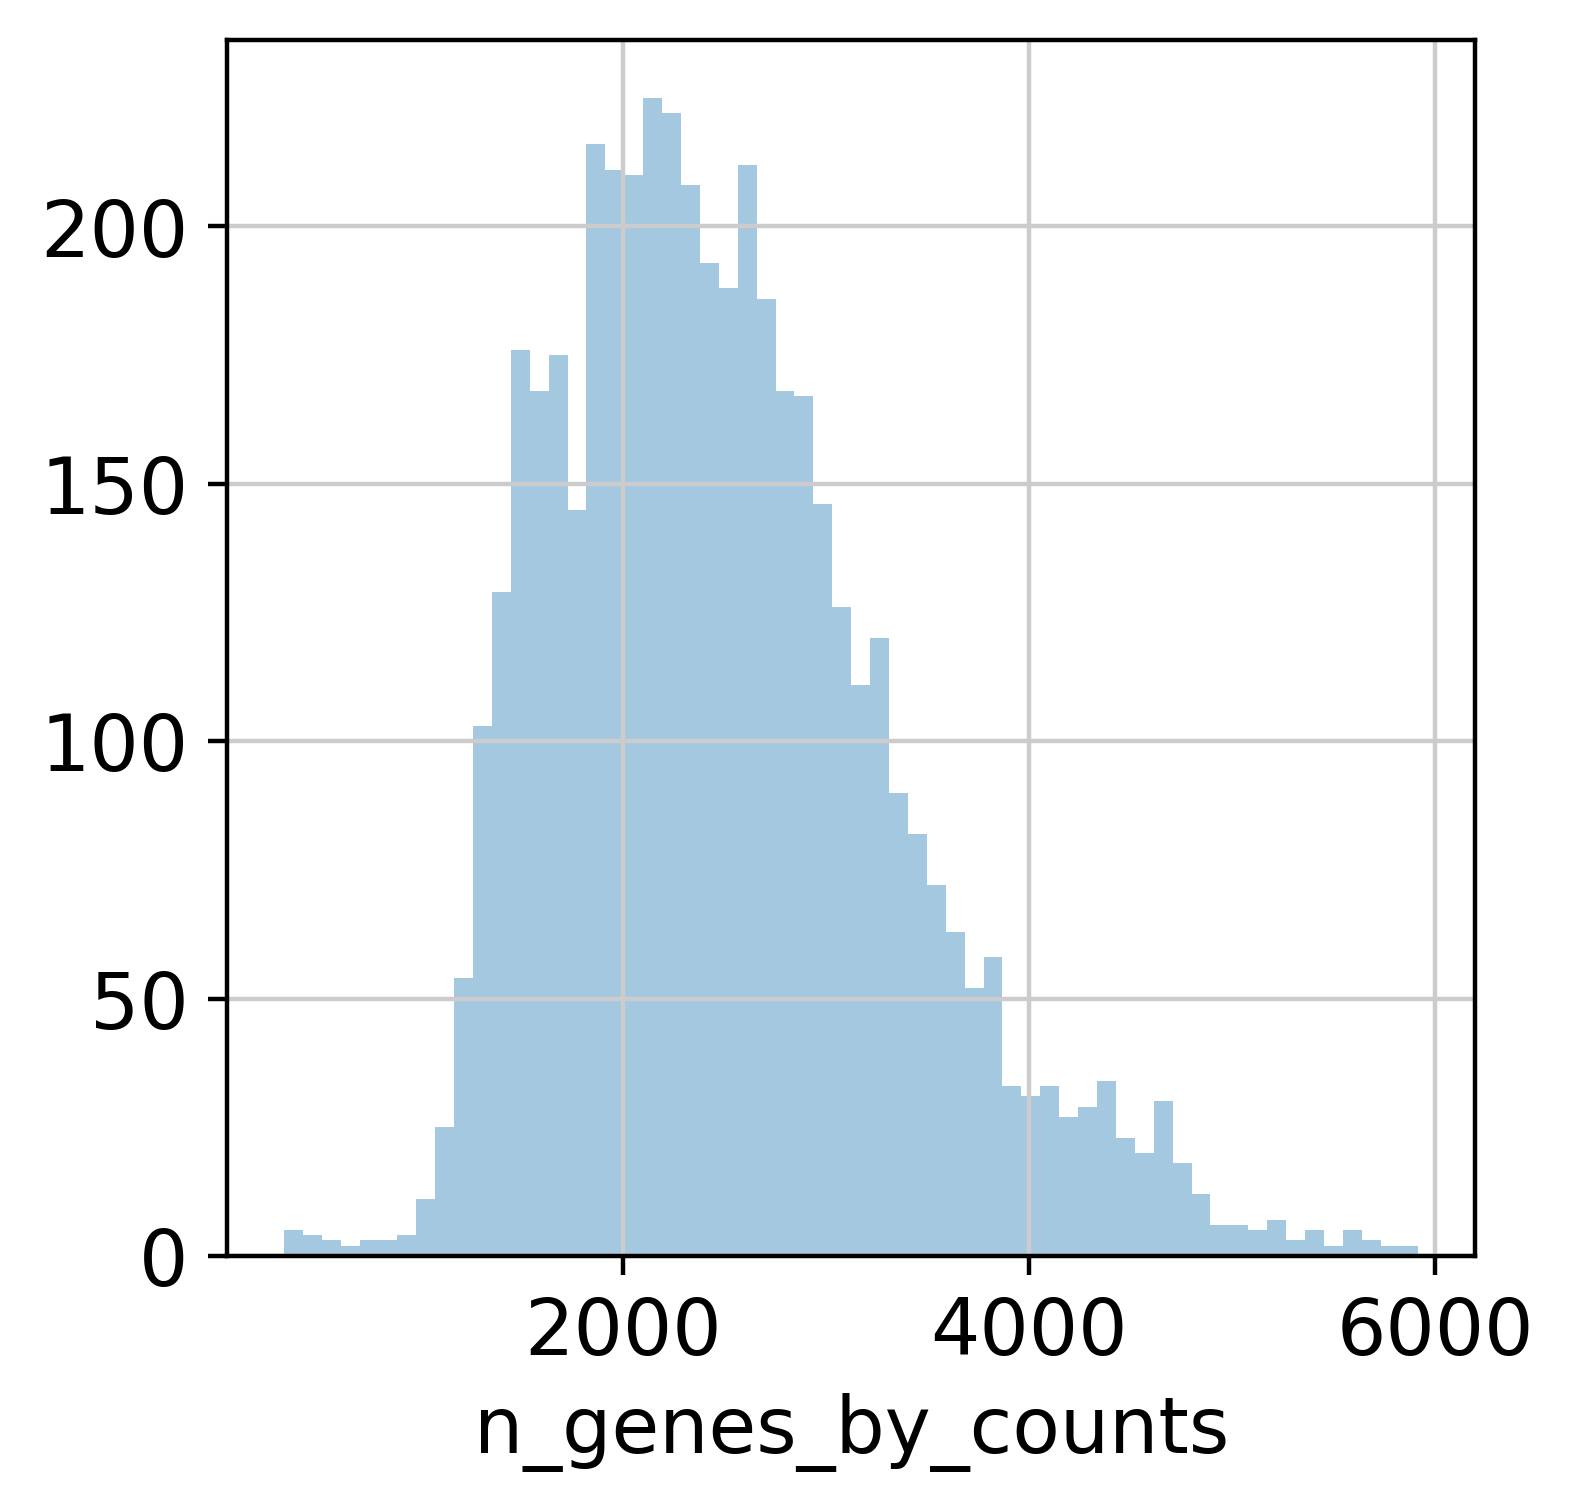

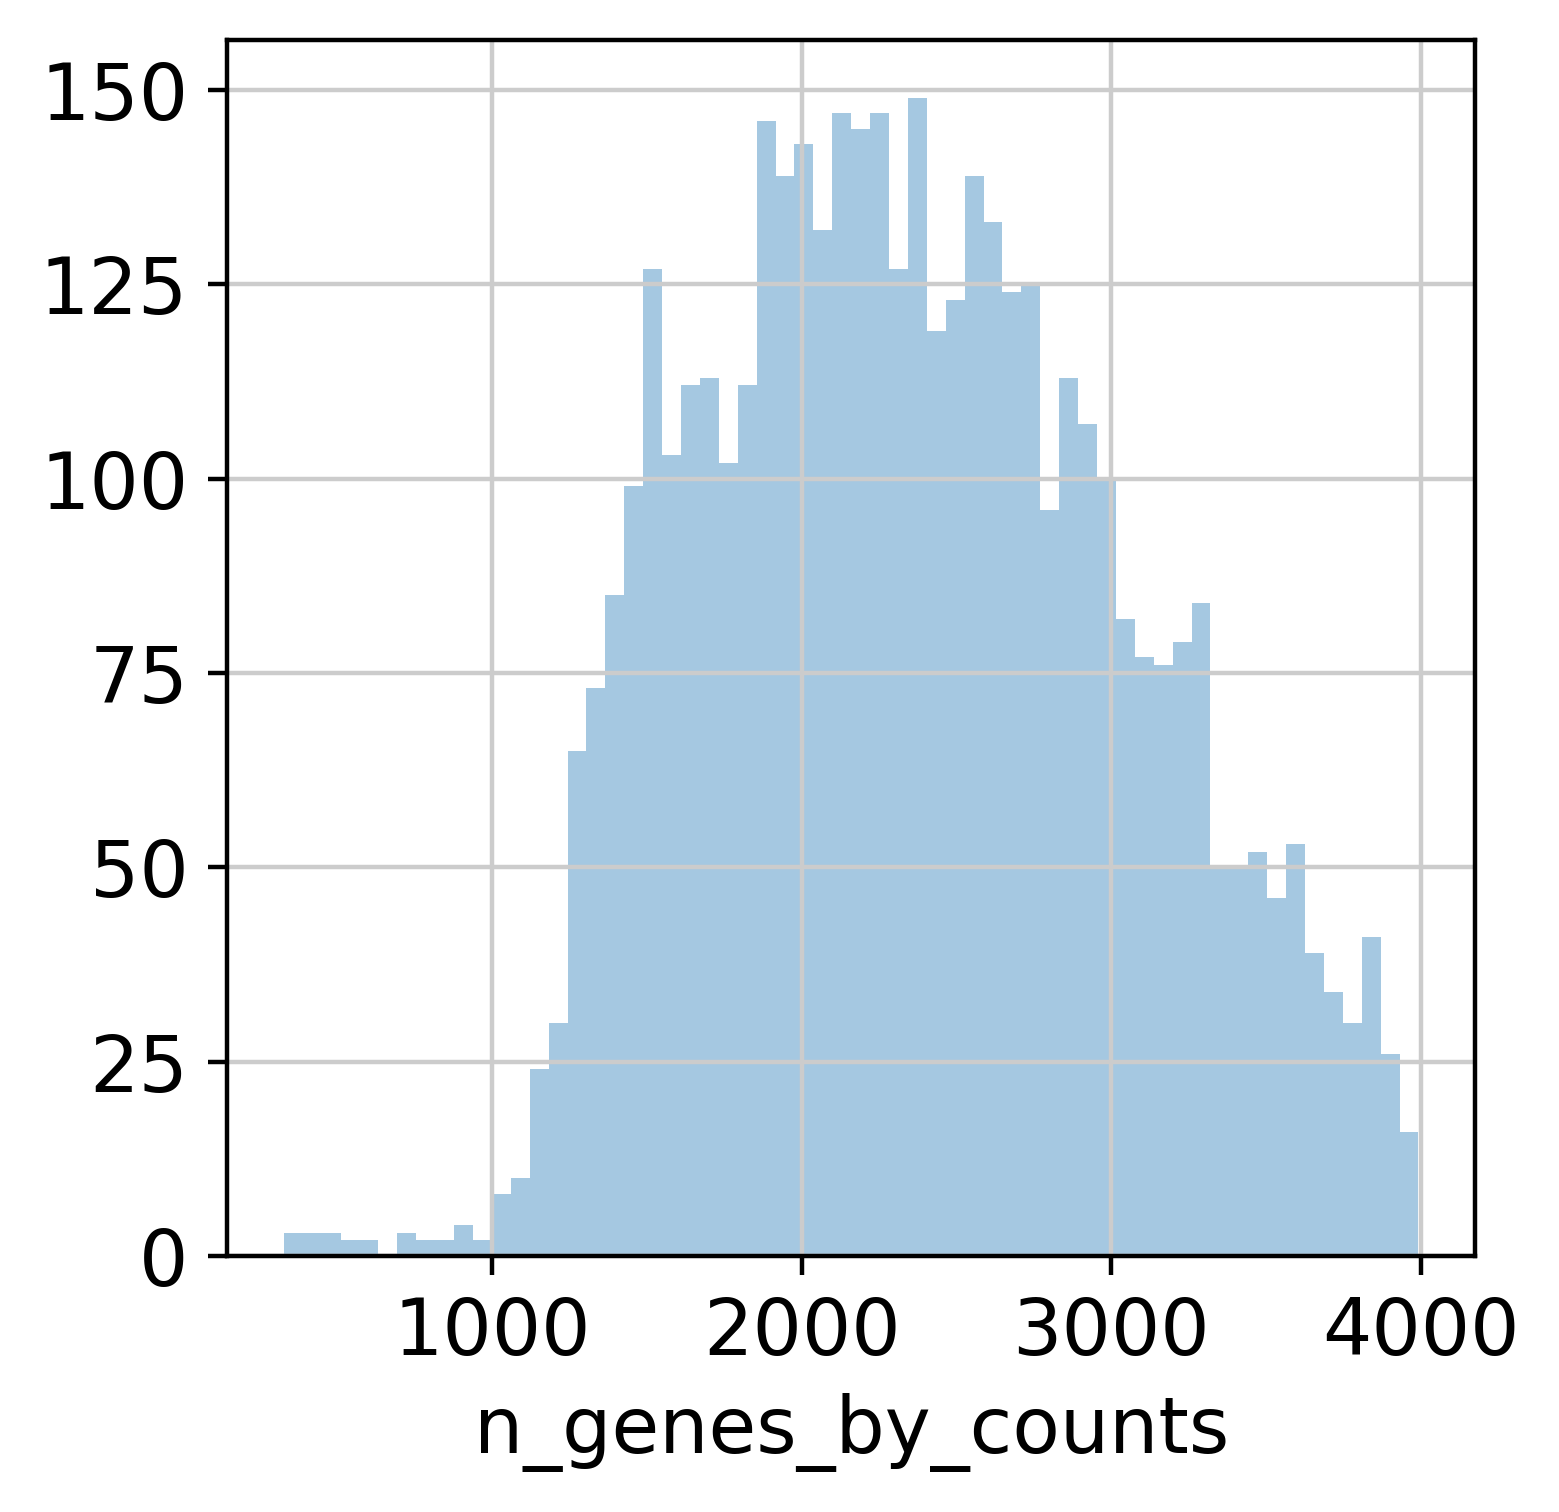

In [16]:
# Thresholding decision: genes
p4 = sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<4000], kde=False, bins=60)
plt.show()

In [19]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 2000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] < 5]
print('Number of cells after mito filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

# Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

sc.pp.filter_genes(adata, min_cells = 1)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of cells: 4672
Number of cells after min count filter: 4672
filtered out 85 cells that have more than 20000 counts
Number of cells after max count filter: 4587
Number of cells after mito filter: 4277
filtered out 18 cells that have less than 1000 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 4259
Total number of genes: 33694
filtered out 11565 genes that are detected in less than 1 cells
Number of genes after cell filter: 22129


# 5 Normalization

In scRNA-seq analyses we can't just take the raw read counts to compare gene expression between cells because the raw read counts are confounded by technical and 'uninteresting' biological variations, such as differences in sequencing depth (the number of reads obtained, also called *library size*; sequencing depth can vary by orders of magnitude across different cells in a scRNA-seq dataset), cell lysis, and reverse transcription efficiency. The goal of normalization is to remove the influence of these confounding factors while preserving true biological heterogeneity (i.e., adjust the dataset such that the variance of a gene is independent of gene abundance and sequencing depth of a cell).

There are several approaches to normalizing scRNA-seq data. In this tutorial we use [`scran`](https://bioconductor.org/packages/release/bioc/html/scran.html) normalization. The `scran` package implements a variant of counts per million (CPM; each column in the counts matrix is divided by its total then multiplied by 1,000,000) size-factor normalization. A "quick cluster" approach is used to get rough clusters of cells to pool together in order to calculate a normalization factor for the sum of each pool. Since each cell is found in many different pools, cell-specific factors can be deconvoluted from the collection of pool-specific factors using linear algebra. This method takes extra steps to counteract assumptions about differentially expressed (DE) genes by estimating a size factor term for each cell pool and utilizing these estimates to approximate a size factor term for individual cells.

Alternatively, [`sctransform`](https://doi.org/10.1186/s13059-019-1874-1) is another great normalization option (and might even be better than `scran` depending on your dataset). `sctransform` models UMI counts using a regularized negative binomial model to remove variation due to sequencing depth. The method first constructs a generalized linear model (GLM) for each gene using sequencing depth as an independent variable and UMI count as response or dependent variable. The parameter estimates are then regularized based on gene expression. A second round of negative binomial regression is applied using the regularized parameters. The output of this model (residuals) is the normalized expression levels for each gene.

In [20]:
# Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [21]:
# Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [22]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

In [23]:
# Delete adata_pp
del adata_pp

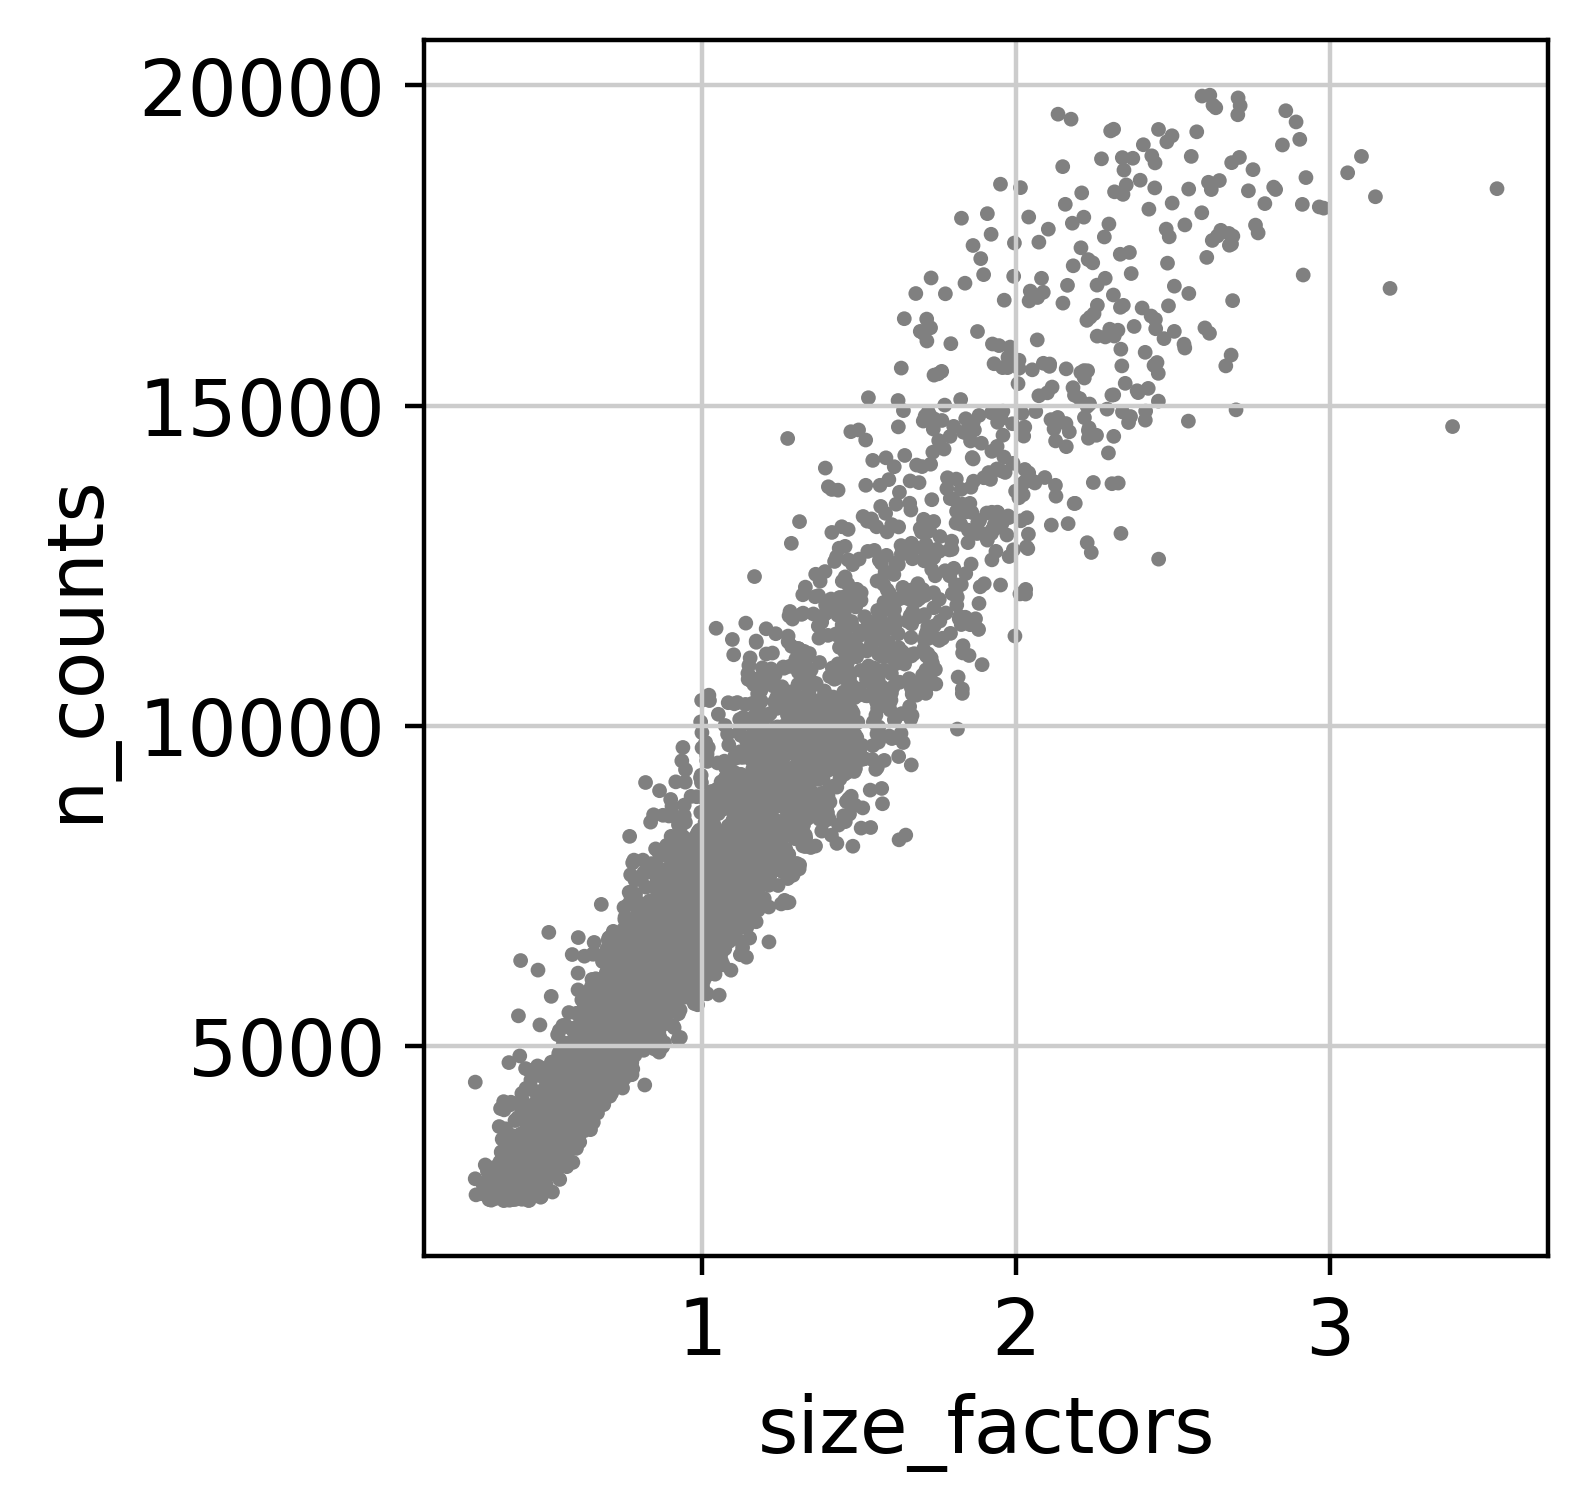

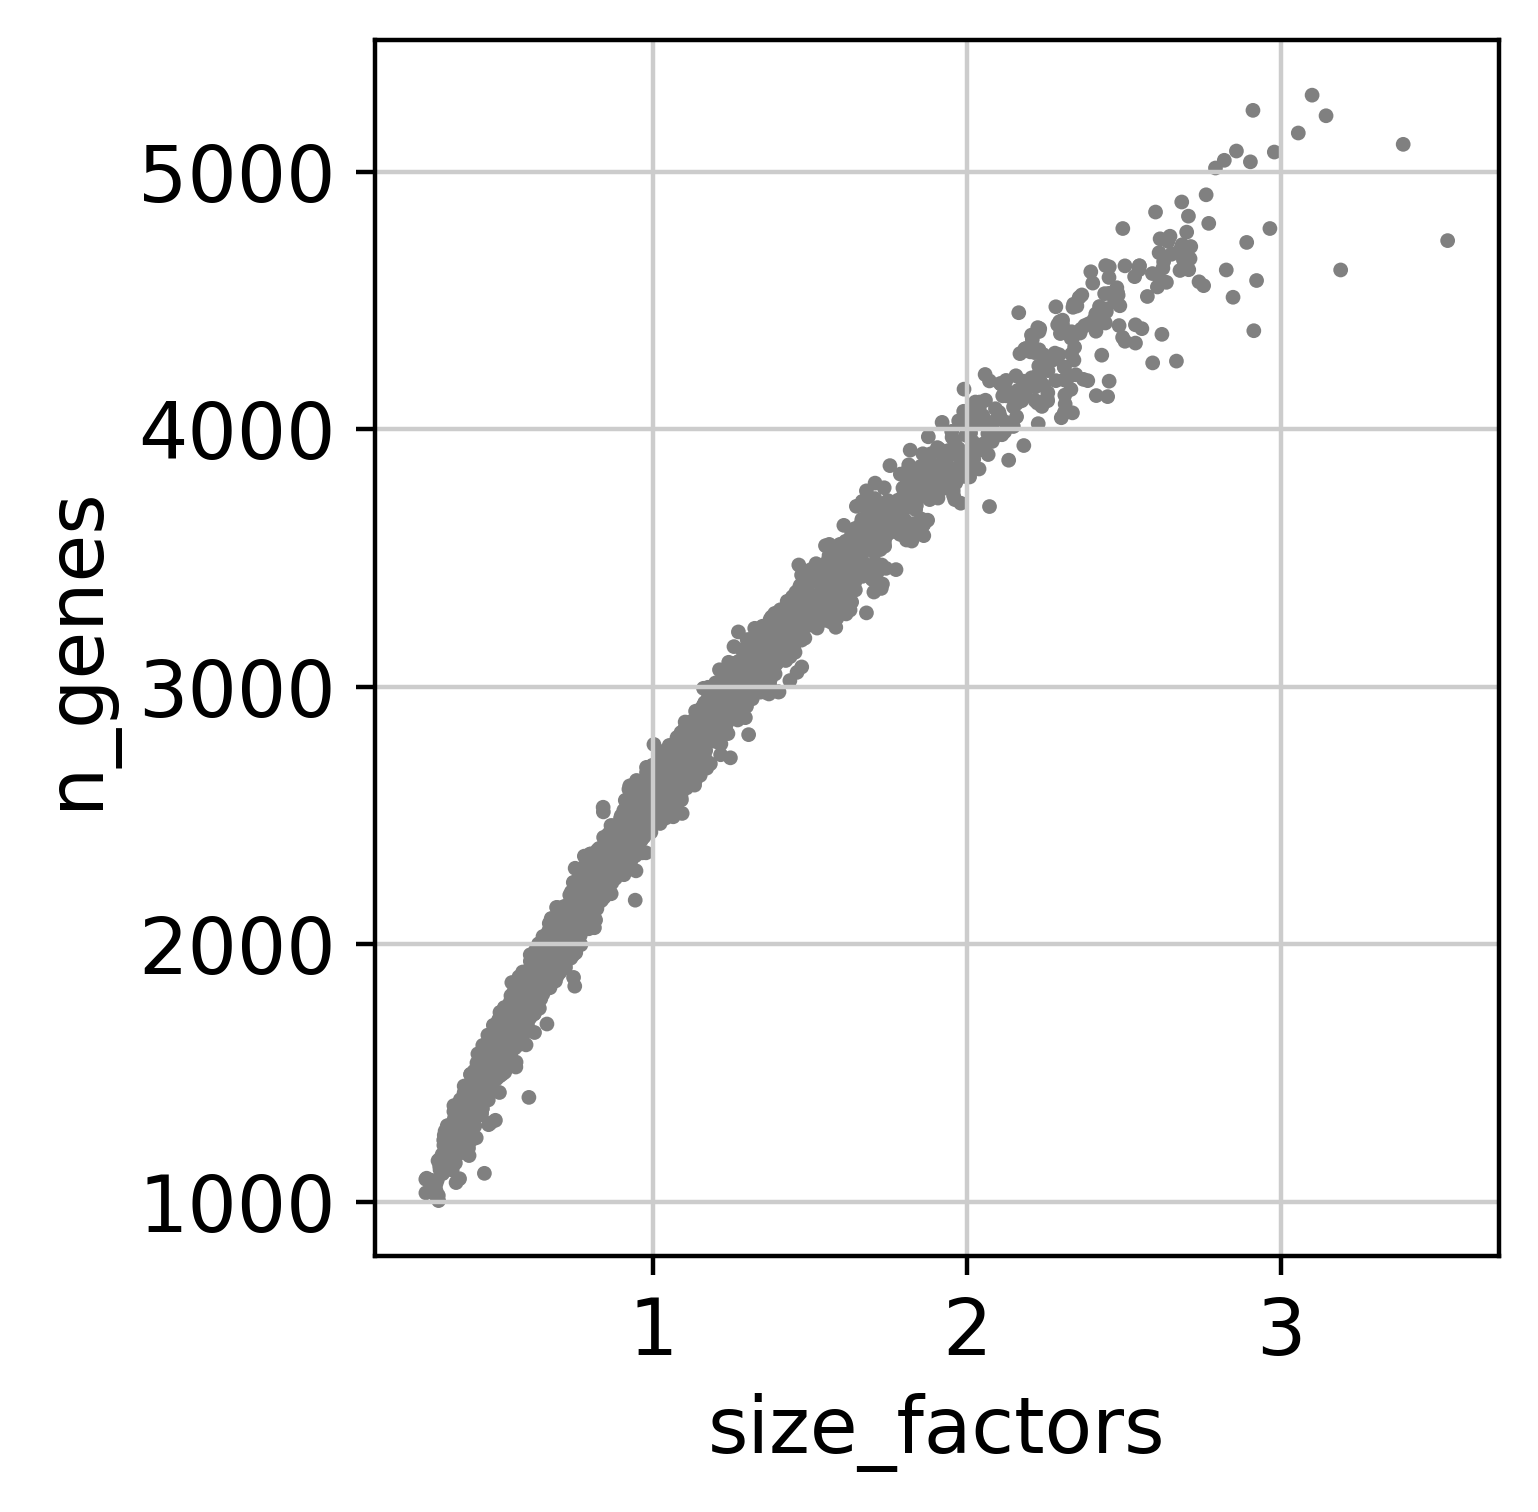

In [25]:
# Visualize the estimated size factors
# Size factors should be non-negative and related to the number of counts and genes per cell as expected

adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

In [26]:
# Keep a copy of the raw count data in a counts layer
# Always save a copy of the raw count data, as some downstream analysis methods require it!
adata.layers["counts"] = adata.X.copy()

In [27]:
# Normalize adata. This results in type(adata.X)=numpy.matrix. 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

# Convert numpy.matrix to sp.sparse.csr.csr_matrix for downstream analysis.
adata.X = sp.sparse.csr_matrix(adata.X)

In [28]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

# 6 Highly Variable Genes

We extract highly variable genes (HVGs) to reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization (and batch correction, if appropriate). HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full dataset is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

There is no good criteria to determine how many HVGs to use. Sometimes you need to experiment with different numbers and pick whatever number gives the most clear and interpretable result. Typically between 1000 and 5000 genes are selected.

In [29]:
# Extract highly variable genes to reduce dimensionality
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


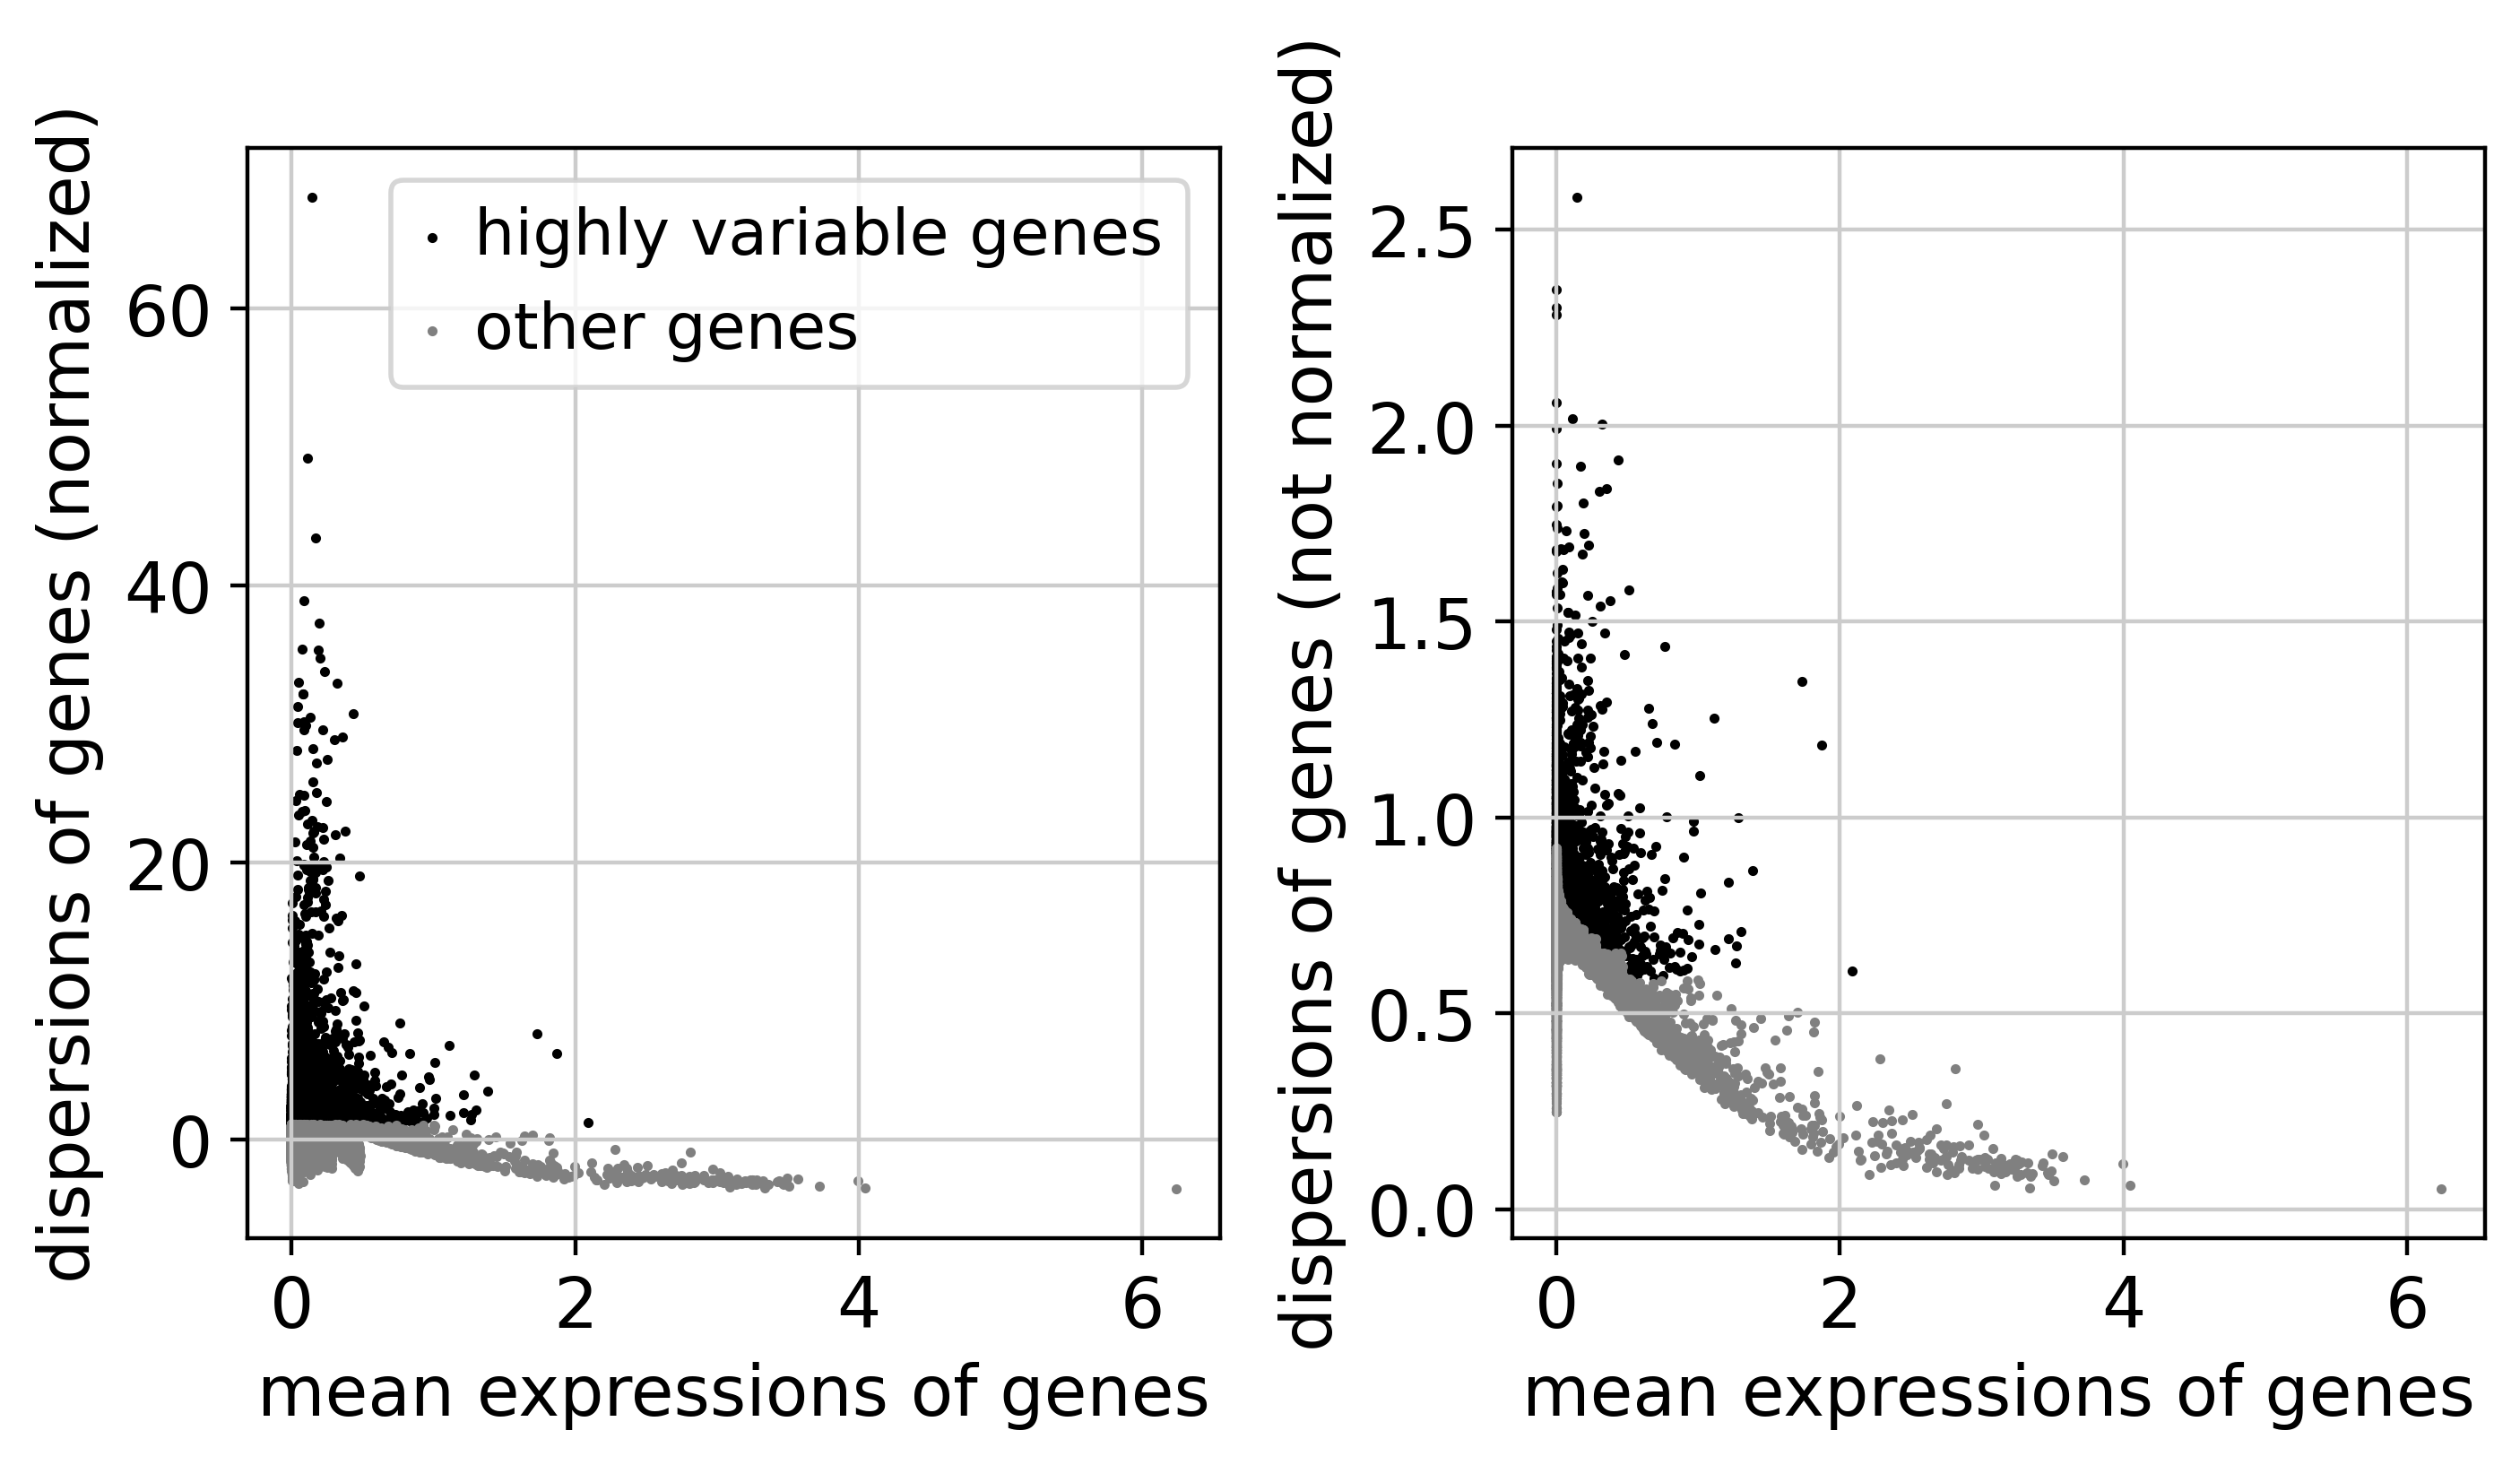

In [30]:
# Plot highly variable genes
# Plots show how data was normalized to select HVGs irrespective of the mean expression of the genes
sc.pl.highly_variable_genes(adata)

# 7 Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. For instance, tsne plots provide great visualization when cells form distinct cell groups, while umap plots preserve trajectory-like structure better. Again, there are no "right" answers!

Wait - aren't we supposed to scale the data?

You can, and lots of people do. I opted not to, as suggested by the scanpy authors. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). They argue that this weighting based on mean expression is a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

In [31]:
# Calculate the visualization
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


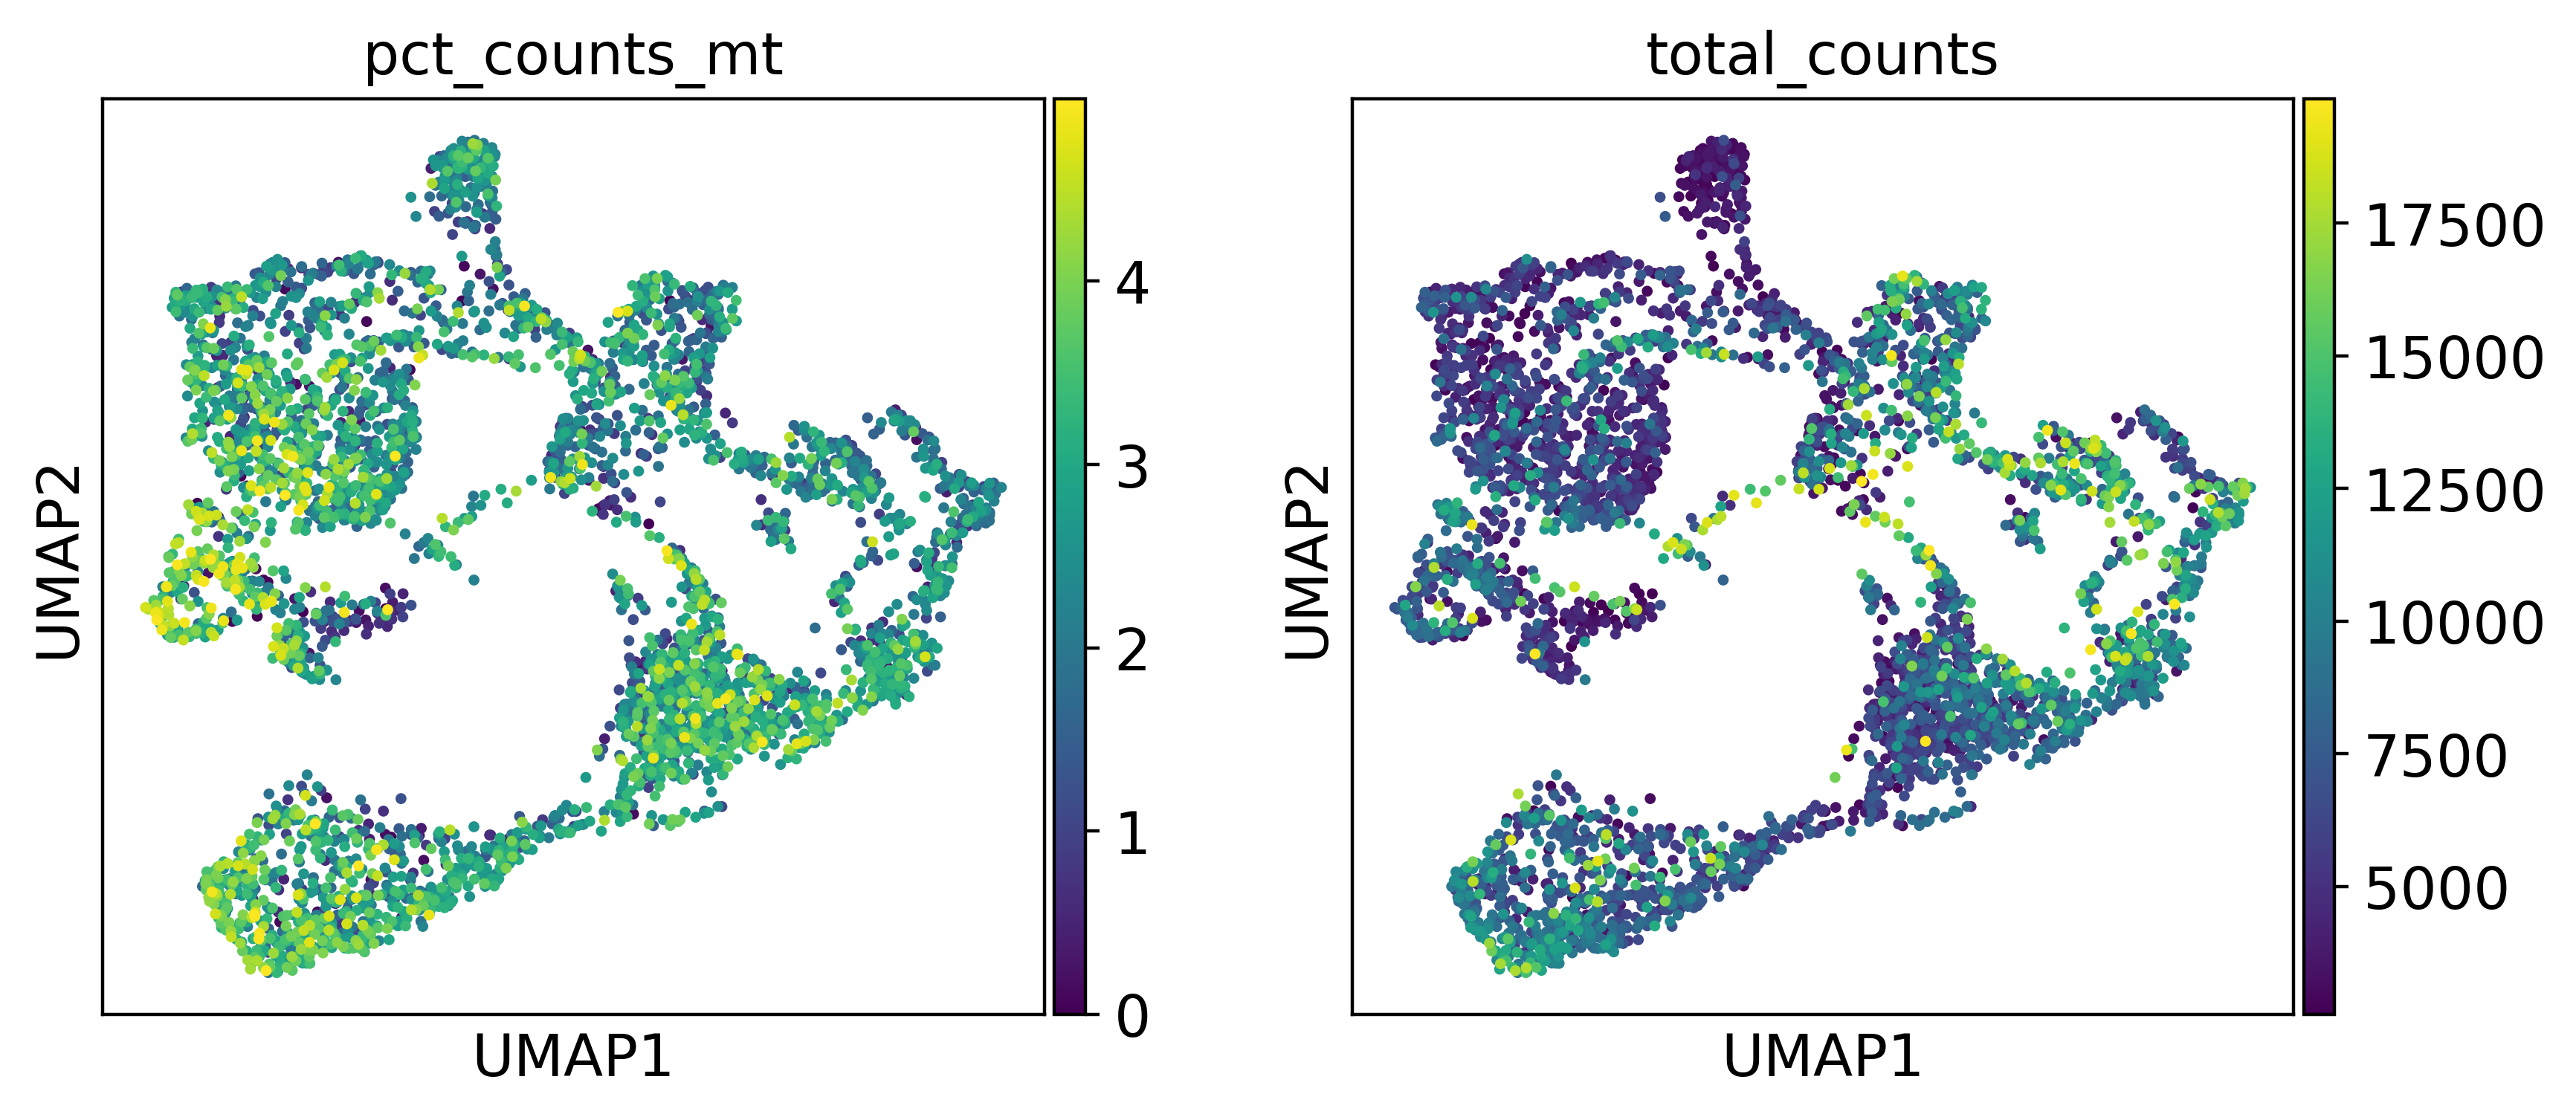

In [32]:
# Plot UMAP
sc.pl.umap(adata, color=['pct_counts_mt', 'total_counts'])

In [34]:
adata

AnnData object with n_obs × n_vars = 4259 × 22129
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [33]:
adata.write(results)